# Packages Imports

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 130)
import numpy as np

import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import (classification_report, 
                             confusion_matrix)

from catboost import CatBoostClassifier, sum_models, Pool

# Read the data

In [2]:
INSIDER_SENARIOS = {
    0: 'Normal',
    1: 'Leaking Data',
    2: 'Churning Employee',
    3: 'Key Logging',
}

In [3]:
FULL_PATH = "./r4.2/ExtractedData/sessionr4.2/"
BALANCED_PATH = "./r4.2/ExtractedData/sessionr4.2_balanced/"
BENIGN_PATH = "./r4.2/ExtractedData/sessionr4.2_benign/"
INSIDER_PATH = "./r4.2/ExtractedData/sessionr4.2_insider/"

In [4]:
cert_balanced = dd.read_parquet(BALANCED_PATH)
cert_balanced = cert_balanced.repartition(npartitions=5)

cert_benign = dd.read_parquet(BENIGN_PATH)
cert_benign = cert_benign.repartition(npartitions=10)

cert_full = dd.read_parquet(FULL_PATH)
cert_full = cert_full.repartition(npartitions=10)

cert_insider = dd.read_parquet(INSIDER_PATH)
cert_insider = cert_insider.repartition(npartitions=5)

In [5]:
X_train = pd.read_parquet("./r4.2/ExtractedData/X_train.parquet")
X_test = pd.read_parquet("./r4.2/ExtractedData/X_test.parquet")
y_train = pd.read_parquet("./r4.2/ExtractedData/y_train.parquet")
y_test = pd.read_parquet("./r4.2/ExtractedData/y_test.parquet")

## CatBoost Model

### Bulk Training Full Data

In [8]:
def print_report(y_true, y_pred):
    """
    Print the classification report

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print(classification_report(y_true, y_pred, zero_division=0))


def plot_cm(y_true, y_pred, labels=None, data_name=None):
    """
    Plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    plt.figure(figsize=(7, 5))
    if labels is None:
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    else:
        sns.heatmap(
            cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
        )
    if data_name is not None:
        plt.title(f"Confusion Matrix for {data_name} Data")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")


def get_results(y_true, y_pred, labels=None, data_name=None):
    """
    Print the classification report and plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print_report(y_true, y_pred)
    plot_cm(y_true, y_pred, labels, data_name)
    plt.show()

In [70]:
cat_model = CatBoostClassifier(iterations=500,
                                depth=7,
                                task_type='GPU',
                                loss_function='MultiClass',
                                verbose=True)

cat_model.fit(X_train, y_train)

Learning rate set to 0.218608
0:	learn: 0.8144713	total: 6.59s	remaining: 54m 46s
1:	learn: 0.5721953	total: 10.7s	remaining: 44m 22s
2:	learn: 0.4236559	total: 14s	remaining: 38m 32s
3:	learn: 0.3225876	total: 17.8s	remaining: 36m 41s
4:	learn: 0.2501325	total: 22.8s	remaining: 37m 32s
5:	learn: 0.1964285	total: 26.3s	remaining: 36m 8s
6:	learn: 0.1558930	total: 29.8s	remaining: 34m 59s
7:	learn: 0.1248128	total: 33.6s	remaining: 34m 24s
8:	learn: 0.1007540	total: 37s	remaining: 33m 41s
9:	learn: 0.0818330	total: 40.2s	remaining: 32m 50s
10:	learn: 0.0670875	total: 43.9s	remaining: 32m 32s
11:	learn: 0.0555722	total: 46.6s	remaining: 31m 35s
12:	learn: 0.0459285	total: 48.2s	remaining: 30m 7s
13:	learn: 0.0385435	total: 54.9s	remaining: 31m 45s
14:	learn: 0.0328271	total: 57.6s	remaining: 31m 1s
15:	learn: 0.0281470	total: 58.7s	remaining: 29m 34s
16:	learn: 0.0242951	total: 1m 5s	remaining: 31m 3s
17:	learn: 0.0212756	total: 1m 9s	remaining: 30m 54s
18:	learn: 0.0188370	total: 1m 10s

In [71]:
cat_model.save_model('cat_model.cbm')

In [6]:
cat_model = CatBoostClassifier().load_model('cat_model.cbm')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4626767
           1       0.99      0.90      0.95       345
           2       0.98      0.66      0.79      8370
           3       1.00      0.93      0.96       173

    accuracy                           1.00   4635655
   macro avg       0.99      0.87      0.92   4635655
weighted avg       1.00      1.00      1.00   4635655



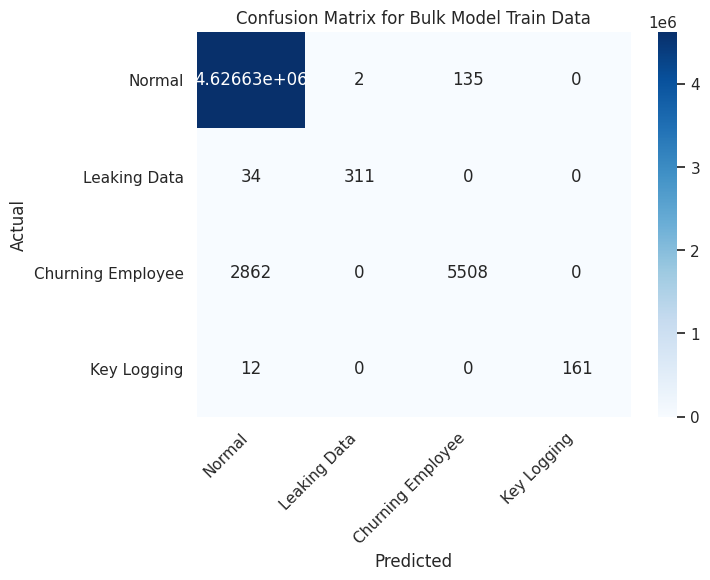

In [8]:
y_pred = cat_model.predict(X_train)

get_results(
    y_train, y_pred, labels=INSIDER_SENARIOS.values(), data_name="Bulk Model Train"
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1156692
           1       0.96      0.83      0.89        86
           2       0.97      0.51      0.67      2093
           3       1.00      0.88      0.94        43

    accuracy                           1.00   1158914
   macro avg       0.98      0.81      0.87   1158914
weighted avg       1.00      1.00      1.00   1158914



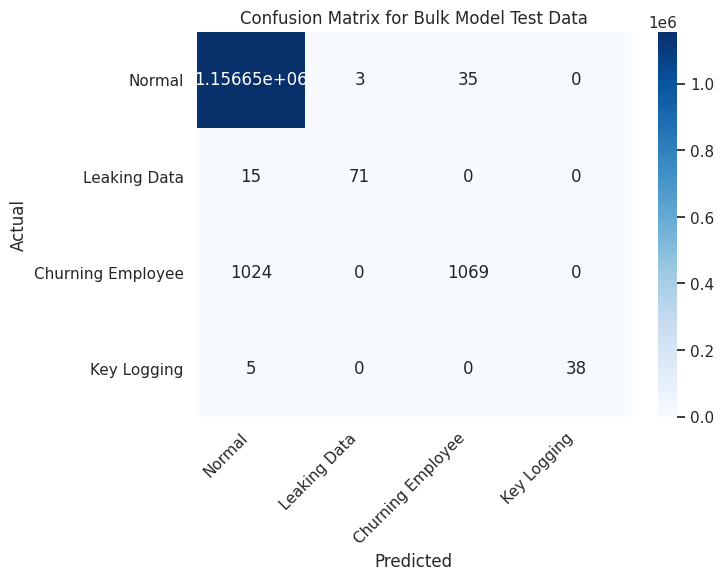

In [9]:
y_pred = cat_model.predict(X_test)

get_results(
    y_test, y_pred, labels=INSIDER_SENARIOS.values(), data_name="Bulk Model Test"
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5783459
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           1.00   5783459
   macro avg       0.33      0.33      0.33   5783459
weighted avg       1.00      1.00      1.00   5783459



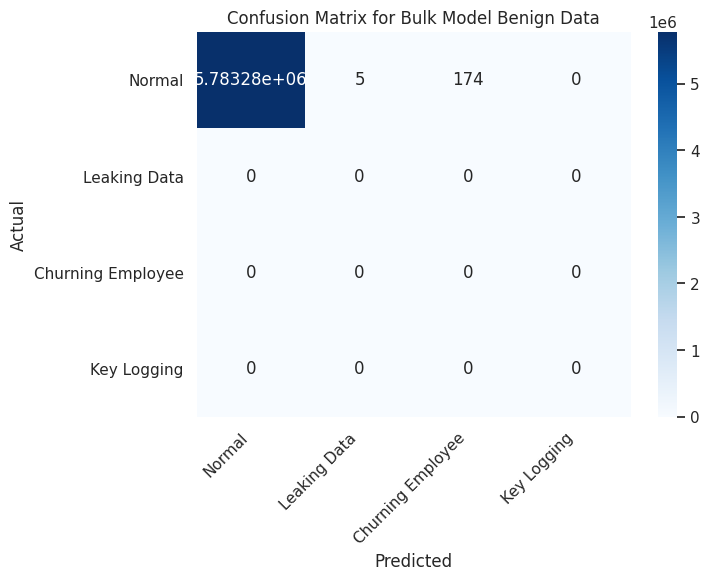

In [9]:
cert_benign["duration"] = cert_benign["duration"] / cert_benign["duration"].max()

y_pred = cat_model.predict(cert_benign.drop("insider", axis=1).compute())

get_results(
    cert_benign["insider"].compute(),
    y_pred,
    labels=INSIDER_SENARIOS.values(),
    data_name="Bulk Model Benign",
)

### Batch Training Full Data

In [26]:
models = []
cert_insider = cert_insider.compute()

for i in range(cert_benign.npartitions):
    benign_partition = cert_benign.get_partition(i).compute()
    partition = pd.concat([benign_partition, cert_insider])
    
    batch = Pool(partition.drop('insider', axis=1), 
                 partition['insider'])
    if i != 0:
        batch.set_baseline(models[-1].predict(batch))

    model = CatBoostClassifier(iterations=500,
                               depth=7,
                               task_type='GPU')
    # Train the model on the partition
    model.fit(partition.drop('insider', axis=1),
                partition['insider'])

    models.append(model.copy())
    del partition, benign_partition

# Combine the models
final_model = sum_models(models)

Learning rate set to 0.396302
0:	learn: 0.4978042	total: 35ms	remaining: 17.5s
1:	learn: 0.3025392	total: 58.1ms	remaining: 14.5s
2:	learn: 0.1980529	total: 85.7ms	remaining: 14.2s
3:	learn: 0.1362610	total: 112ms	remaining: 13.9s
4:	learn: 0.0980415	total: 135ms	remaining: 13.3s
5:	learn: 0.0735986	total: 154ms	remaining: 12.7s
6:	learn: 0.0580500	total: 171ms	remaining: 12.1s
7:	learn: 0.0467667	total: 191ms	remaining: 11.7s
8:	learn: 0.0401480	total: 208ms	remaining: 11.4s
9:	learn: 0.0333663	total: 233ms	remaining: 11.4s
10:	learn: 0.0295977	total: 251ms	remaining: 11.2s
11:	learn: 0.0274119	total: 271ms	remaining: 11s
12:	learn: 0.0258294	total: 293ms	remaining: 11s
13:	learn: 0.0242010	total: 318ms	remaining: 11s
14:	learn: 0.0232187	total: 341ms	remaining: 11s
15:	learn: 0.0222627	total: 364ms	remaining: 11s
16:	learn: 0.0203490	total: 386ms	remaining: 11s
17:	learn: 0.0198245	total: 405ms	remaining: 10.9s
18:	learn: 0.0196435	total: 423ms	remaining: 10.7s
19:	learn: 0.0192242	t

Learning rate set to 0.436329
0:	learn: 0.4410188	total: 27.6ms	remaining: 13.8s
1:	learn: 0.2609506	total: 53.5ms	remaining: 13.3s
2:	learn: 0.1687849	total: 80.2ms	remaining: 13.3s
3:	learn: 0.1164038	total: 105ms	remaining: 13s
4:	learn: 0.0828188	total: 132ms	remaining: 13.1s
5:	learn: 0.0624657	total: 155ms	remaining: 12.8s
6:	learn: 0.0494215	total: 176ms	remaining: 12.4s
7:	learn: 0.0399901	total: 200ms	remaining: 12.3s
8:	learn: 0.0340875	total: 223ms	remaining: 12.2s
9:	learn: 0.0303417	total: 243ms	remaining: 11.9s
10:	learn: 0.0271307	total: 270ms	remaining: 12s
11:	learn: 0.0239882	total: 297ms	remaining: 12.1s
12:	learn: 0.0220160	total: 319ms	remaining: 11.9s
13:	learn: 0.0210972	total: 343ms	remaining: 11.9s
14:	learn: 0.0200253	total: 343ms	remaining: 11.9s
15:	learn: 0.0189870	total: 2.65s	remaining: 1m 25s
16:	learn: 0.0176261	total: 2.67s	remaining: 1m 20s
17:	learn: 0.0170921	total: 2.7s	remaining: 1m 16s
18:	learn: 0.0160587	total: 2.73s	remaining: 1m 12s
19:	learn

Learning rate set to 0.41635
0:	learn: 0.4829432	total: 29.5ms	remaining: 14.7s
1:	learn: 0.2971110	total: 60.2ms	remaining: 15s
2:	learn: 0.2003674	total: 82.9ms	remaining: 13.7s
3:	learn: 0.1413404	total: 82.9ms	remaining: 13.7s
4:	learn: 0.1059493	total: 2.39s	remaining: 4m 55s
5:	learn: 0.0833600	total: 2.41s	remaining: 3m 58s
6:	learn: 0.0662097	total: 2.44s	remaining: 3m 20s
7:	learn: 0.0548549	total: 2.47s	remaining: 2m 53s
8:	learn: 0.0482358	total: 2.49s	remaining: 2m 32s
9:	learn: 0.0425541	total: 2.51s	remaining: 2m 16s
10:	learn: 0.0399127	total: 2.53s	remaining: 2m 3s
11:	learn: 0.0367395	total: 2.55s	remaining: 1m 53s
12:	learn: 0.0351804	total: 2.57s	remaining: 1m 44s
13:	learn: 0.0336279	total: 2.59s	remaining: 1m 36s
14:	learn: 0.0319358	total: 2.61s	remaining: 1m 30s
15:	learn: 0.0308198	total: 2.63s	remaining: 1m 24s
16:	learn: 0.0299972	total: 2.64s	remaining: 1m 19s
17:	learn: 0.0289633	total: 2.66s	remaining: 1m 15s
18:	learn: 0.0275510	total: 2.68s	remaining: 1m 

Learning rate set to 0.432426
0:	learn: 0.4513288	total: 35ms	remaining: 17.5s
1:	learn: 0.2703349	total: 74.5ms	remaining: 18.6s
2:	learn: 0.1769542	total: 101ms	remaining: 16.8s
3:	learn: 0.1217100	total: 137ms	remaining: 17s
4:	learn: 0.0879024	total: 169ms	remaining: 16.7s
5:	learn: 0.0687124	total: 194ms	remaining: 15.9s
6:	learn: 0.0544320	total: 221ms	remaining: 15.6s
7:	learn: 0.0446055	total: 247ms	remaining: 15.2s
8:	learn: 0.0385713	total: 247ms	remaining: 15.2s
9:	learn: 0.0345505	total: 2.55s	remaining: 2m 18s
10:	learn: 0.0311884	total: 2.57s	remaining: 2m 5s
11:	learn: 0.0283494	total: 2.6s	remaining: 1m 55s
12:	learn: 0.0265440	total: 2.63s	remaining: 1m 46s
13:	learn: 0.0255858	total: 2.65s	remaining: 1m 39s
14:	learn: 0.0240489	total: 2.68s	remaining: 1m 32s
15:	learn: 0.0225386	total: 2.71s	remaining: 1m 27s
16:	learn: 0.0216050	total: 2.73s	remaining: 1m 22s
17:	learn: 0.0211008	total: 2.75s	remaining: 1m 18s
18:	learn: 0.0207255	total: 2.77s	remaining: 1m 14s
19:	l

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   4626767
           1       0.64      1.00      0.78       345
           2       0.14      0.98      0.25      8370
           3       0.31      1.00      0.48       173

    accuracy                           0.99   4635655
   macro avg       0.52      0.99      0.63   4635655
weighted avg       1.00      0.99      0.99   4635655



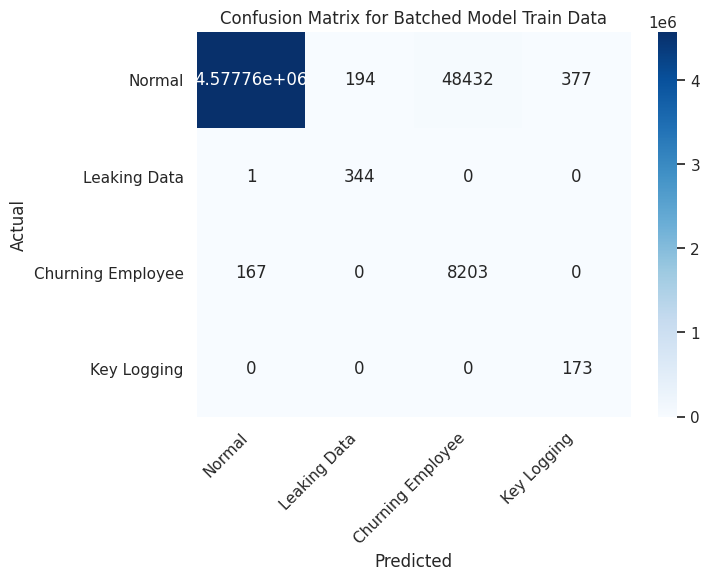

In [43]:
y_pred = final_model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
get_results(
    y_train,
    y_pred,
    labels=INSIDER_SENARIOS.values(),
    data_name="Batched Model Train",
)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1156692
           1       0.74      1.00      0.85        86
           2       0.06      0.99      0.12      2093
           3       0.32      1.00      0.48        43

    accuracy                           0.97   1158914
   macro avg       0.53      0.99      0.61   1158914
weighted avg       1.00      0.97      0.98   1158914



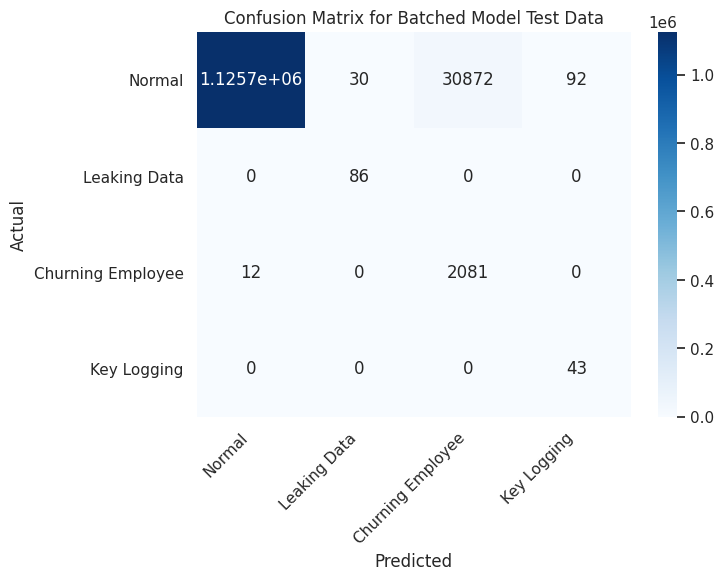

In [44]:
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
get_results(
    y_test,
    y_pred,
    labels=INSIDER_SENARIOS.values(),
    data_name="Batched Model Test",
)

### Bulk Training Balanced Data

In [34]:
cat_model = CatBoostClassifier(
    iterations=500,
    depth=7,
    task_type="GPU",
    loss_function="MultiClass",
    verbose=True,
)

cat_model.fit(
    cert_balanced.drop("insider", axis=1).compute(), 
    cert_balanced["insider"].compute()
)

Learning rate set to 0.424829
0:	learn: 0.4718153	total: 45.2ms	remaining: 22.6s
1:	learn: 0.2887142	total: 76.9ms	remaining: 19.1s
2:	learn: 0.1924515	total: 104ms	remaining: 17.2s
3:	learn: 0.1372408	total: 129ms	remaining: 15.9s
4:	learn: 0.1020491	total: 158ms	remaining: 15.6s
5:	learn: 0.0819962	total: 183ms	remaining: 15.1s
6:	learn: 0.0665442	total: 213ms	remaining: 15s
7:	learn: 0.0557505	total: 241ms	remaining: 14.8s
8:	learn: 0.0492378	total: 267ms	remaining: 14.6s
9:	learn: 0.0439937	total: 300ms	remaining: 14.7s
10:	learn: 0.0413313	total: 322ms	remaining: 14.3s
11:	learn: 0.0393909	total: 344ms	remaining: 14s
12:	learn: 0.0380196	total: 364ms	remaining: 13.6s
13:	learn: 0.0363459	total: 390ms	remaining: 13.5s
14:	learn: 0.0338900	total: 419ms	remaining: 13.5s
15:	learn: 0.0310261	total: 452ms	remaining: 13.7s
16:	learn: 0.0302097	total: 477ms	remaining: 13.6s
17:	learn: 0.0295064	total: 503ms	remaining: 13.5s
18:	learn: 0.0288120	total: 527ms	remaining: 13.3s
19:	learn: 0.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4626767
           1       0.91      0.99      0.95       345
           2       0.51      0.90      0.65      8370
           3       0.92      1.00      0.96       173

    accuracy                           1.00   4635655
   macro avg       0.83      0.97      0.89   4635655
weighted avg       1.00      1.00      1.00   4635655



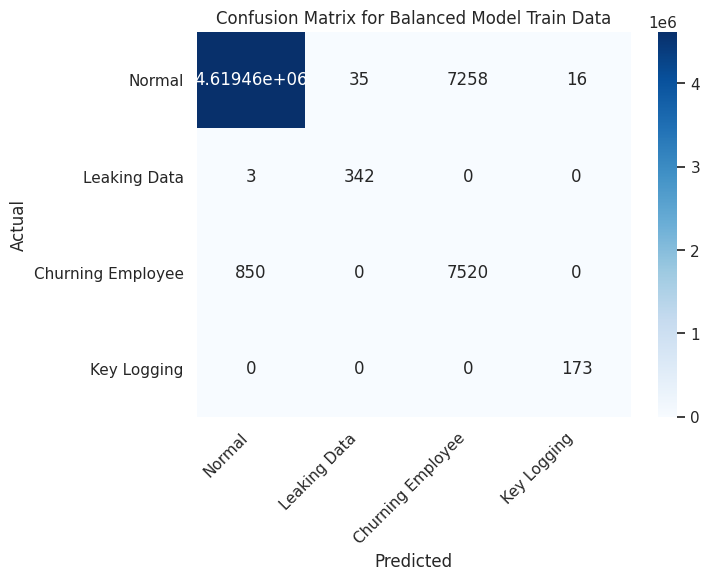

In [41]:
y_pred = cat_model.predict(X_train)
get_results(
    y_train,
    y_pred,
    labels=INSIDER_SENARIOS.values(),
    data_name="Balanced Model Train",
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1156692
           1       0.94      0.98      0.96        86
           2       0.56      0.96      0.70      2093
           3       0.98      1.00      0.99        43

    accuracy                           1.00   1158914
   macro avg       0.87      0.98      0.91   1158914
weighted avg       1.00      1.00      1.00   1158914



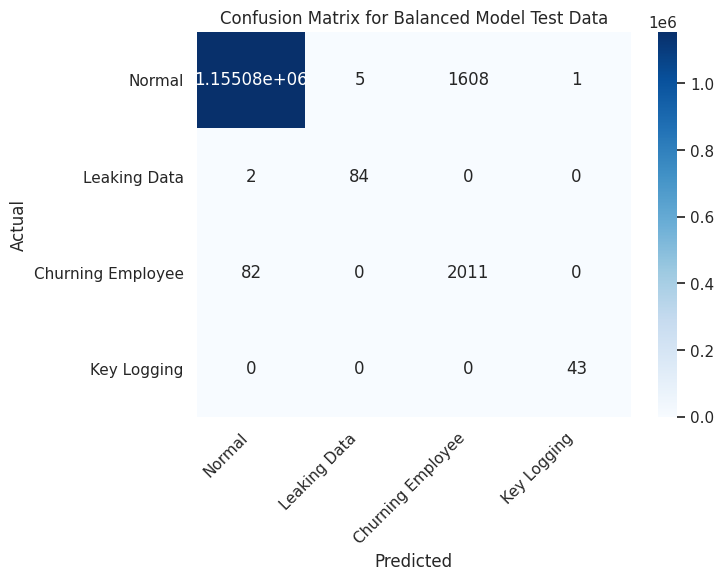

In [42]:
y_pred = cat_model.predict(X_test)
get_results(
    y_test,
    y_pred,
    labels=INSIDER_SENARIOS.values(),
    data_name="Balanced Model Test",
)